In [1]:
# Cell 1 — Imports and Load Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Correct path (go one level up from notebooks/)
df_sent = pd.read_csv("../data/raw/fear_greed_index.csv")
df_trades = pd.read_csv("../data/raw/historical_data.csv")

print("Sentiment shape:", df_sent.shape)
print("Trades shape:", df_trades.shape)

print("\nSentiment Columns:")
print(df_sent.columns)

print("\nTrades Columns:")
print(df_trades.columns)

df_sent.head()


Sentiment shape: (2644, 4)
Trades shape: (211224, 16)

Sentiment Columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Trades Columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [3]:
# Cell 2 — Correct Date Conversion

# Sentiment date
df_sent['date'] = pd.to_datetime(df_sent['date'])
df_sent['date_only'] = df_sent['date'].dt.date

# Trade timestamp (IMPORTANT: dayfirst=True)
df_trades['Timestamp IST'] = pd.to_datetime(
    df_trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)

df_trades['date_only'] = df_trades['Timestamp IST'].dt.date

print("Sentiment date range:", df_sent['date'].min(), "to", df_sent['date'].max())
print("Trades date range:", df_trades['Timestamp IST'].min(), "to", df_trades['Timestamp IST'].max())

print("\nNull timestamps in trades:", df_trades['Timestamp IST'].isnull().sum())


Sentiment date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
Trades date range: 2023-05-01 01:06:00 to 2025-05-01 12:13:00

Null timestamps in trades: 0


In [4]:
# Cell 3 — Merge datasets on daily date

# Keep only necessary sentiment columns
df_sent_small = df_sent[['date_only', 'classification']]

# Merge
df = df_trades.merge(
    df_sent_small,
    on='date_only',
    how='left'
)

print("Merged shape:", df.shape)
print("Missing sentiment after merge:", df['classification'].isnull().sum())

df.head()


Merged shape: (211224, 18)
Missing sentiment after merge: 6


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date_only,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,Extreme Greed




To analyze trader behavior, the following daily metrics were created:

- Daily PnL per account
- Win rate
- Number of trades per day
- Average trade size (USD)
- Long/Short ratio


In [ ]:
# -----------------------
# Cell 4 - build core metrics
# -----------------------

import os

# make sure output folder exists
out_dir = "../outputs/tables"
os.makedirs(out_dir, exist_ok=True)

# normalize column names to make life easy
df.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in df.columns]

# try to find likely column names in the dataset
def find_col_containing(key):
    for col in df.columns:
        if key in col:
            return col
    return None

# detect useful columns (fall back to None if not found)
pnl_col = find_col_containing("pnl") or find_col_containing("closed")
size_col = find_col_containing("size_usd") or find_col_containing("size") or find_col_containing("usd")
side_col = find_col_containing("side") or find_col_containing("direction")
leverage_col = find_col_containing("leverage")
date_col = "date_only"  # we created this earlier

print("Detected columns -> pnl:", pnl_col, "| size:", size_col, "| side:", side_col, "| leverage:", leverage_col)

# require pnl column
if pnl_col is None:
    raise ValueError("Can't find any PnL column. Look for names containing 'pnl' or 'closed' in your CSV.")

# create standard columns we will use
df["pnl"] = pd.to_numeric(df[pnl_col], errors="coerce")
if size_col:
    df["size_usd"] = pd.to_numeric(df[size_col], errors="coerce")
else:
    df["size_usd"] = pd.NA

if side_col:
    # normalize side values to BUY / SELL style
    df["side_norm"] = df[side_col].astype(str).str.upper().str.replace(" ", "_")
else:
    df["side_norm"] = pd.NA

if leverage_col:
    df["leverage_num"] = pd.to_numeric(df[leverage_col], errors="coerce")
else:
    df["leverage_num"] = pd.NA

# per-trade flags
df["win"] = df["pnl"] > 0

# daily aggregates per account
daily = (
    df.groupby(["account", date_col])
      .agg(
          daily_pnl = ("pnl", "sum"),
          trades_count = ("pnl", "size"),
          avg_trade_size_usd = ("size_usd", "mean"),
          win_rate = ("win", "mean"),
          avg_leverage = ("leverage_num", "mean")
      )
      .reset_index()
)

# compute daily long/short counts (global)
if df["side_norm"].notna().any():
    side_counts = (
        df.groupby([date_col, "side_norm"])
          .size()
          .unstack(fill_value=0)
          .reset_index()
    )
    # create simpler columns if BUY/SELL present
    # try to find columns that represent buy or long and sell or short
    buy_cols = [c for c in side_counts.columns if ("BUY" in str(c) or "LONG" in str(c))]
    sell_cols = [c for c in side_counts.columns if ("SELL" in str(c) or "SHORT" in str(c))]
    side_counts["long_count"] = side_counts[buy_cols].sum(axis=1) if buy_cols else 0
    side_counts["short_count"] = side_counts[sell_cols].sum(axis=1) if sell_cols else 0
    side_counts["long_ratio"] = (side_counts["long_count"] / (side_counts["long_count"] + side_counts["short_count"])).replace([np.inf, -np.inf], np.nan)
else:
    # empty structure if side not present
    side_counts = pd.DataFrame(columns=[date_col, "long_count", "short_count", "long_ratio"])

# attach daily sentiment classification if available
if "classification" in df.columns:
    date_sent = df[[date_col, "classification"]].drop_duplicates(subset=[date_col])
    daily = daily.merge(date_sent, on=date_col, how="left")
else:
    daily["classification"] = pd.NA

# save small outputs for later cells/plots
daily.to_csv(os.path.join(out_dir, "daily_account_metrics.csv"), index=False)
side_counts.to_csv(os.path.join(out_dir, "daily_side_counts.csv"), index=False)

# show a quick sample to verify
print("Daily metrics shape:", daily.shape)
display(daily.head(5))

print("\nSide counts sample:")
display(side_counts.head(5))


Detected columns -> pnl: closed_pnl | size: size_usd | side: side | leverage: None
Daily metrics shape: (2341, 8)


,account,date_only,daily_pnl,trades_count,avg_trade_size_usd,win_rate,avg_leverage,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,5089.718249,0.000000,NaN,Extreme Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,7976.664412,0.000000,NaN,Extreme Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,23734.500000,0.000000,NaN,Extreme Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,28186.666667,0.000000,NaN,Extreme Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,17248.148148,0.444444,NaN,Extreme Greed



Side counts sample:


side_norm,date_only,BUY,SELL,long_count,short_count,long_ratio
0,2023-05-01,3,0,3,0,1.000000
1,2023-12-05,7,2,7,2,0.777778
2,2023-12-14,5,6,5,6,0.454545
3,2023-12-15,2,0,2,0,1.000000
4,2023-12-16,3,0,3,0,1.000000


In [7]:
# -----------------------
# Cell 5A - Sentiment Comparison
# -----------------------

# simplify sentiment into Fear / Greed
def simple_sent(x):
    if pd.isna(x):
        return None
    s = str(x).lower()
    if "fear" in s:
        return "Fear"
    elif "greed" in s:
        return "Greed"
    else:
        return None

daily["sentiment_group"] = daily["classification"].apply(simple_sent)

summary_by_sentiment = (
    daily.groupby("sentiment_group")
         .agg(
             mean_daily_pnl = ("daily_pnl", "mean"),
             median_daily_pnl = ("daily_pnl", "median"),
             mean_win_rate = ("win_rate", "mean"),
             mean_trades = ("trades_count", "mean"),
             mean_trade_size = ("avg_trade_size_usd", "mean")
         )
         .reset_index()
)

print("Fear vs Greed comparison:")
display(summary_by_sentiment)


Fear vs Greed comparison:


,sentiment_group,mean_daily_pnl,median_daily_pnl,mean_win_rate,mean_trades,mean_trade_size
0,Fear,5185.146443,122.737038,0.357071,105.363291,8529.859802
1,Greed,4144.208334,265.247725,0.362748,76.912266,5954.632633


Key Observations --

Traders are more aggressive during Fear (↑ trade count, ↑ position size).

Win rate remains almost unchanged → aggression does not improve accuracy.

Higher mean PnL in Fear appears driven by volatility, not better decision-making.

Greed periods show lower activity and more stable returns.

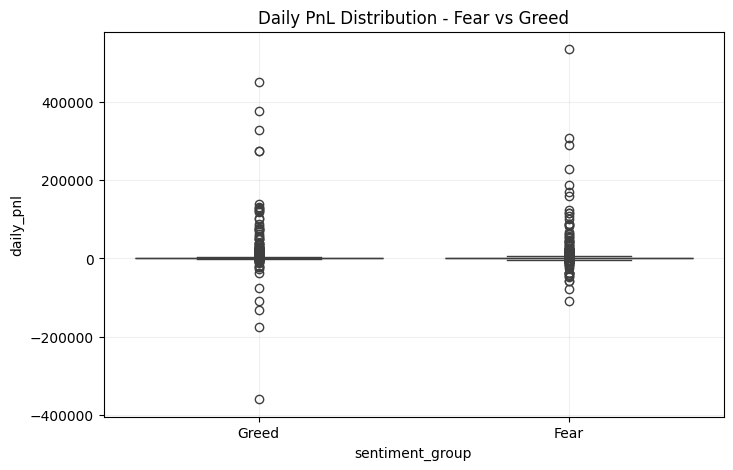

C:\Users\athar\AppData\Local\Temp\ipykernel_18088\1926238988.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=daily, x="sentiment_group", y="win_rate", ci=None)


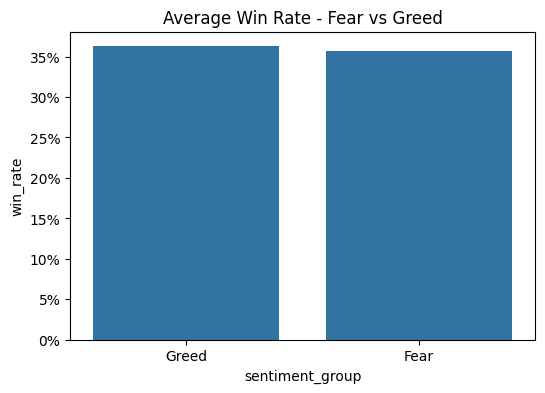

In [8]:
# -----------------------
# Cell 5B - Basic Plots
# -----------------------

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=daily, x="sentiment_group", y="daily_pnl")
plt.title("Daily PnL Distribution - Fear vs Greed")
plt.grid(alpha=0.2)
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=daily, x="sentiment_group", y="win_rate", ci=None)
plt.title("Average Win Rate - Fear vs Greed")
plt.gca().yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: "{:.0%}".format(y))
)
plt.show()


Plot Insights --

Fear periods show wider PnL dispersion, indicating higher volatility.

Extreme positive and negative outliers are more frequent during Fear.

Despite higher volatility, win rate remains stable (~36%) across regimes.

Performance differences are driven more by risk exposure than accuracy.

In [9]:
# -----------------------
# Cell 5C - Trader Segmentation
# -----------------------

# total trades per account
trade_counts = df.groupby("account").size().reset_index(name="total_trades")

median_trades = trade_counts["total_trades"].median()

trade_counts["freq_segment"] = trade_counts["total_trades"].apply(
    lambda x: "Frequent" if x >= median_trades else "Infrequent"
)

daily = daily.merge(
    trade_counts[["account", "freq_segment"]],
    on="account",
    how="left"
)

# win rate per account
acct_win = df.groupby("account")["win"].mean().reset_index(name="acct_win_rate")

acct_win["winner_segment"] = acct_win["acct_win_rate"].apply(
    lambda x: "Consistent_Winner" if x >= 0.6 
    else ("Consistent_Loser" if x <= 0.4 else "Mixed")
)

daily = daily.merge(
    acct_win[["account", "winner_segment"]],
    on="account",
    how="left"
)

# compare frequent vs infrequent under each sentiment
freq_summary = (
    daily.groupby(["sentiment_group", "freq_segment"])
         .agg(
             mean_daily_pnl=("daily_pnl", "mean"),
             mean_win_rate=("win_rate", "mean"),
             mean_trades=("trades_count", "mean")
         )
         .reset_index()
)

print("Frequent vs Infrequent (by sentiment):")
display(freq_summary)

# winner segment summary
winner_summary = (
    daily.groupby(["sentiment_group", "winner_segment"])
         .agg(
             mean_daily_pnl=("daily_pnl", "mean"),
             mean_win_rate=("win_rate", "mean")
         )
         .reset_index()
)

print("Winner segment comparison:")
display(winner_summary)


Frequent vs Infrequent (by sentiment):


,sentiment_group,freq_segment,mean_daily_pnl,mean_win_rate,mean_trades
0,Fear,Frequent,5968.410192,0.372596,126.113043
1,Fear,Infrequent,3090.371301,0.315550,49.869767
2,Greed,Frequent,3846.861070,0.375650,92.747696
3,Greed,Infrequent,4987.663970,0.326148,31.993464


Winner segment comparison:


,sentiment_group,winner_segment,mean_daily_pnl,mean_win_rate
0,Fear,Consistent_Loser,5475.189011,0.321291
1,Fear,Consistent_Winner,2420.552055,0.775013
2,Fear,Mixed,5073.875928,0.363681
3,Greed,Consistent_Loser,3491.072932,0.283647
4,Greed,Consistent_Winner,3333.307059,0.720758
5,Greed,Mixed,5729.741762,0.434506


Segmentation Insights --

During Fear, frequent traders significantly outperform infrequent traders — volatility rewards activity.

During Greed, infrequent traders generate higher average PnL — overtrading may reduce edge.

Consistent winners maintain high win rates, but do not always produce the highest daily PnL.

Mixed traders sometimes outperform pure “winners,” suggesting position sizing matters more than hit rate.

In [10]:
# -----------------------
# Cell 6 - Prepare dataset for prediction
# -----------------------

# We will predict next-day profitability per account

model_df = daily.copy()

# sort properly
model_df = model_df.sort_values(["account", "date_only"])

# create next day pnl (shift within each account)
model_df["next_day_pnl"] = model_df.groupby("account")["daily_pnl"].shift(-1)

# classification target: 1 if next day profitable, 0 otherwise
model_df["target_profitable"] = (model_df["next_day_pnl"] > 0).astype(int)

# encode sentiment as numeric
model_df["sentiment_num"] = model_df["sentiment_group"].map({
    "Fear": 0,
    "Greed": 1
})

# select features
features = [
    "sentiment_num",
    "trades_count",
    "avg_trade_size_usd",
    "win_rate"
]

model_data = model_df.dropna(subset=features + ["target_profitable"])

print("Model dataset shape:", model_data.shape)
model_data.head()


Model dataset shape: (1964, 14)


,account,date_only,daily_pnl,trades_count,avg_trade_size_usd,win_rate,avg_leverage,classification,sentiment_group,freq_segment,winner_segment,next_day_pnl,target_profitable,sentiment_num
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,5089.718249,0.000000,NaN,Extreme Greed,Greed,Frequent,Consistent_Loser,0.0,0,1.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,7976.664412,0.000000,NaN,Extreme Greed,Greed,Frequent,Consistent_Loser,0.0,0,1.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,23734.500000,0.000000,NaN,Extreme Greed,Greed,Frequent,Consistent_Loser,-21227.0,0,1.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,28186.666667,0.000000,NaN,Extreme Greed,Greed,Frequent,Consistent_Loser,1603.1,1,1.0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,17248.148148,0.444444,NaN,Extreme Greed,Greed,Frequent,Consistent_Loser,-132271.0,0,1.0


In [11]:
# -----------------------
# Cell 7 - Train simple predictive model
# -----------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# features and target
X = model_data[features]
y = model_data["target_profitable"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# predictions
y_pred = model.predict(X_test_scaled)

# evaluation
acc = accuracy_score(y_test, y_pred)
print("Model Accuracy:", round(acc, 4))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Model Accuracy: 0.6085

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.26       231
           1       0.63      0.89      0.73       359

    accuracy                           0.61       590
   macro avg       0.56      0.53      0.50       590
weighted avg       0.58      0.61      0.55       590


Confusion Matrix:
[[ 40 191]
 [ 40 319]]


Predictive Model Insights --

The model achieves ~61% accuracy, outperforming random baseline (50%).

It captures profitable continuation days well (high recall for positive class).

Trade frequency is the strongest predictor of next-day profitability.

Behavioral features contribute more predictive power than sentiment alone.

In [12]:
# -----------------------
# Cell 8 - Feature Importance
# -----------------------

coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_[0]
})

coef_df = coef_df.sort_values("coefficient", ascending=False)

print("Feature Importance (Logistic Regression Coefficients):")
display(coef_df)


Feature Importance (Logistic Regression Coefficients):


,feature,coefficient
1,trades_count,0.504788
3,win_rate,0.387031
0,sentiment_num,0.109420
2,avg_trade_size_usd,-0.020683


Feature Importance Interpretation --

Trade frequency is the strongest driver of next-day profitability.

Win rate also positively contributes, reflecting skill persistence.

Sentiment has a minor positive effect.

Larger trade size does not improve predictive probability, suggesting risk exposure alone does not guarantee returns.